# Text Classification using Language Modeling

- In this notebook, we will practice text pre-processing and language modeling for text classification.
- We will use a subset of the Reuters-21578 data set, a standard data set for evaluating text classification systems.
- You can access data from this link: https://www.kaggle.com/datasets/nltkdata/reuters
- The "reuters21578.zip" file contains 21578 news stories from Reuters newswire classified under one or more of 118 categories.
- There are 21 SGML files in this zip file, each containing 1000 news articles, except the last file, which contains 578 articles.
- We should pre-process the SGML files to extract the training and test sets.
- We will build a text classifier that assigns an input test document to one of the top five classes in the Reuters-21578 corpus:

  **earn, acquisitions, grain, crude, and money-fx.**

In [1]:
import os
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk import bigrams, trigrams
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Data Pre-Processing

In [2]:
# Define the directory for the folder "reuters21578" with SGML files
data_directory = r'C:\Users\said_\OneDrive\Masaüstü\github\Natural Language Processing\Datasets\reuters21578'

In [3]:
# Define a function to obtain training data
def parse_sgml_file(file_path):
    with open(file_path, 'r', encoding='latin-1') as file:
        soup = BeautifulSoup(file, 'html.parser')
        documents = soup.find_all('reuters')
        data = []
        for doc in documents:
            document_id = doc.get('newid')
            topics = [cat.text for cat in doc.topics.find_all('d')]
            text = doc.find('text').text.strip()
            data.append({'Document_ID': document_id, 'Topics': topics, 'Text': text})
        return data

# Define a function to obtain test data
def create_dataframe(directory, start_file, end_file):
    file_paths = [os.path.join(directory, f"reut2-{i:03d}.sgm") for i in range(start_file, end_file + 1)]
    data = []
    for file_path in file_paths:
        data.extend(parse_sgml_file(file_path))
    return pd.DataFrame(data)

# Create a dataframe for training data (reut2-000.sgm to reut2-020.sgm)
train_df = create_dataframe(data_directory, start_file=0, end_file=20)

# Create a dataframe for test data (reut2-021.sgm)
test_df = pd.DataFrame(parse_sgml_file(os.path.join(data_directory, 'reut2-021.sgm')))

print(f"Original training size: {train_df.shape}")
print(f"Original test size: {test_df.shape}")

Original training size: (21000, 3)
Original test size: (578, 3)


In [4]:
train_df.head()

,Document_ID,Topics,Text
0,1,[cocoa],"\nBAHIA COCOA REVIEW\n SALVADOR, Feb 26 - ..."
1,2,[],\nSTANDARD OIL <SRD> TO FORM FINANCIAL UNIT\n...
2,3,[],\nTEXAS COMMERCE BANCSHARES <TCB> FILES PLAN\...
3,4,[],\nTALKING POINT/BANKAMERICA <BAC> EQUITY OFFE...
4,5,"[grain, wheat, corn, barley, oat, sorghum]",\nNATIONAL AVERAGE PRICES FOR FARMER-OWNED RE...


In [5]:
# Set the topics of each observation according to desired_topics
desired_topics = ["earn", "acq", "grain", "crude", "money-fx"]

# 1) Training Set
n_train = train_df.shape[0]
excluded_news_train = list()

for i in range(n_train):
    topic_list = train_df.loc[i, "Topics"]
    
    if len(topic_list) == 0:
        excluded_news_train.append(i)
    else:
        count = 0
        for j in topic_list:
            if j in desired_topics:
                final_topic = j
                count += 1
        if count == 1:
            train_df.loc[i, "Topics"] = final_topic  # Corrected
        else:
            excluded_news_train.append(i)

# 2) Test Set
n_test = test_df.shape[0]
excluded_news_test = list()

for i in range(n_test):
    topic_list = test_df.loc[i, "Topics"]
    
    if len(topic_list) == 0:
        excluded_news_test.append(i)
    else:
        count = 0
        for j in topic_list:
            if j in desired_topics:
                final_topic = j
                count += 1
        if count == 1:
            test_df.loc[i, "Topics"] = final_topic  # Corrected
        else:
            excluded_news_test.append(i)

# Exclude the observations that are empty OR do not include any of the desired_topics
new_training = train_df.drop(index=excluded_news_train).reset_index(drop=True)
new_test = test_df.drop(index=excluded_news_test).reset_index(drop=True)

# Apply case-folding to the text columns
new_training["Text"] = new_training["Text"].str.lower()
new_test["Text"] = new_test["Text"].str.lower()

print(f"Final training size: {new_training.shape}")
print(f"Final test size: {new_test.shape}")

Final training size: (8078, 3)
Final test size: (289, 3)


In [6]:
# Check the number of desired topics for the training
print(f"Final shape of the training data: {new_training.shape}")
new_training["Topics"].value_counts()

Final shape of the training data: (8078, 3)


Topics
earn        3803
acq         2331
money-fx     767
grain        612
crude        565
Name: count, dtype: int64

In [7]:
# Check the number of desired topics for the test set
print(f"Final shape of the test data: {new_test.shape}")
new_test["Topics"].value_counts()

Final shape of the test data: (289, 3)


Topics
earn        151
acq          72
money-fx     29
crude        28
grain         9
Name: count, dtype: int64

## Language Modeling: N-Gram Language Models

### 1) Unigram Model

In [8]:
# Tokenize the text and create a unigram model
def build_unigram_model(text_data):
    
    unigram_tokens = [word_tokenize(text) for text in text_data]
    flattened_tokens = [token for sublist in unigram_tokens for token in sublist]
    # Count the occurrences of each token (unigram)
    unigram_model = Counter(flattened_tokens)
    
    return unigram_model

# Build unigram language model
training_text = new_training['Text']
unigram_model = build_unigram_model(training_text)

# Check if smoothing necessary
zero_count = 0
for i in unigram_model.keys():
    if unigram_model[i] == 0:
        count += 1
        
if count == 0:
    print("No token with zero observation >> Smoothing is not required!")
else:
    print("Number of biagrams with zero observations: {count} >> Smoothing is required!")

No token with zero observation >> Smoothing is not required!


In [9]:
# Text Classification: Unigram & Multinomial Naive Bayes Classifier 
X_train, y_train = new_training['Text'], new_training['Topics']
X_test, y_test = new_test['Text'], new_test['Topics']

# Convert text into numerical features (unigrams)
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
X_train_transformed = vectorizer.transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

# Define a classification model
unigram_model = MultinomialNB()

# Train the model
unigram_model.fit(X_train_transformed, y_train)

# Make predictions over the test set
preds = unigram_model.predict(X_test_transformed)

# Classification results
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         acq       1.00      1.00      1.00        72
       crude       0.97      1.00      0.98        28
        earn       1.00      1.00      1.00       151
       grain       1.00      0.89      0.94         9
    money-fx       1.00      1.00      1.00        29

    accuracy                           1.00       289
   macro avg       0.99      0.98      0.98       289
weighted avg       1.00      1.00      1.00       289



<Figure size 800x600 with 0 Axes>

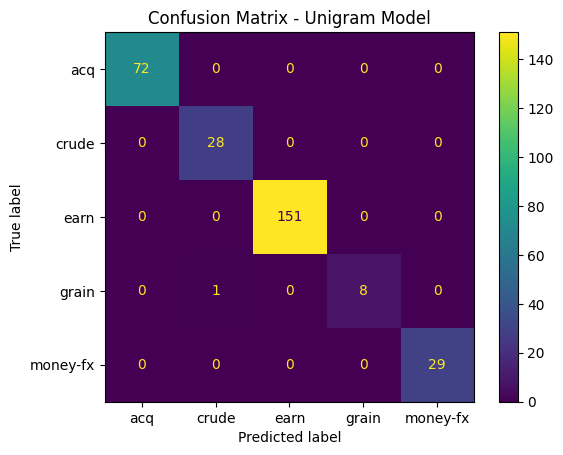

In [10]:
# Initiate a confusion matrix
cm = confusion_matrix(y_test, preds)

# Get unique target labels
labels = sorted(y_test.unique())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.title("Confusion Matrix - Unigram Model")
plt.show()

In [11]:
# Obtain the unigram's macro average results for the classification evaluation metrics
uni_macro_avg = classification_report(y_test, preds, output_dict=True)["macro avg"]
uni_macro_avg

{'precision': 0.993103448275862,
 'recall': 0.9777777777777779,
 'f1-score': 0.9847265221878224,
 'support': 289.0}

In [12]:
# Final Check: Laplace Smoothing
# Compare the classification result with and without Laplace Smoothing
unigram_no_laplace = MultinomialNB()
# Apply Laplace smoothing by adding one to the zero-observed instances
unigram_laplace = MultinomialNB(alpha=1.0)

# Train the model
unigram_no_laplace.fit(X_train_transformed, y_train)
unigram_laplace.fit(X_train_transformed, y_train)

# Make predictions over the test set and compare macro averaged F1 scores
fscore_no_laplace = f1_score(y_test, unigram_no_laplace.predict(X_test_transformed), average="macro")
fscore_laplace = f1_score(y_test, unigram_laplace.predict(X_test_transformed), average="macro")

if fscore_no_laplace == fscore_laplace:
    print("No difference, smoothing is not necessary.")

No difference, smoothing is not necessary.


### 2) Bigram Model

In [13]:
# Tokenize the text and create a bigram model
def build_bigram_model(text_series):
    # Tokenize the text and create bigrams
    bigram_tokens = [list(bigrams(word_tokenize(text))) for text in text_series]
    flattened_bigrams = [bigram for sublist in bigram_tokens for bigram in sublist]
    
    # Count the occurrences of each bigram
    bigram_model = Counter(flattened_bigrams)
    
    return bigram_model

# Build a bigram language model
training_text = new_training['Text']
bigram_model = build_bigram_model(training_text)

# Check if smoothing necessary
zero_count = 0
for i in bigram_model.keys():
    if bigram_model[i] == 0:
        count += 1
        
if count == 0:
    print("No token with zero observation >> Smoothing is not required!")
else:
    print("Number of biagrams with zero observation: {count} >> Smoothing is required!")

No token with zero observation >> Smoothing is not required!


In [14]:
# Text Classification: Bigram & Multinomial Naive Bayes Classifier 
X_train, y_train = new_training['Text'], new_training['Topics']
X_test, y_test = new_test['Text'], new_test['Topics']

# Convert text into numerical features (bigrams)
vectorizer = CountVectorizer(ngram_range=(2, 2))
vectorizer.fit(X_train)
X_train_transformed = vectorizer.transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

# Define a classification model
bigram_model = MultinomialNB()

# Train the model
bigram_model.fit(X_train_transformed, y_train)

# Make predictions over the test set
preds = bigram_model.predict(X_test_transformed)

# Classification results
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         acq       1.00      0.99      0.99        72
       crude       0.97      1.00      0.98        28
        earn       0.99      1.00      0.99       151
       grain       1.00      0.89      0.94         9
    money-fx       1.00      0.97      0.98        29

    accuracy                           0.99       289
   macro avg       0.99      0.97      0.98       289
weighted avg       0.99      0.99      0.99       289



<Figure size 800x600 with 0 Axes>

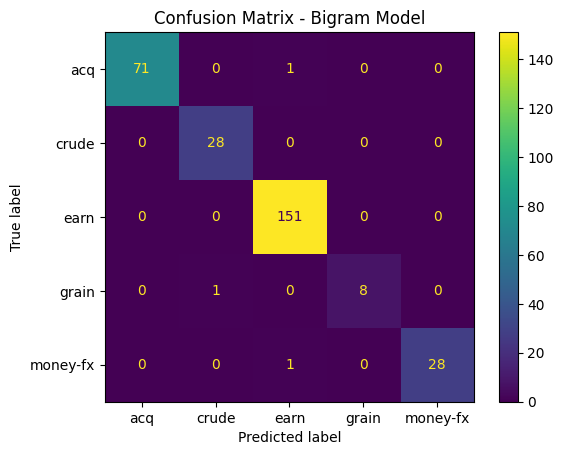

In [15]:
# Initiate a confusion matrix
cm = confusion_matrix(y_test, preds)

# Get unique target labels
labels = sorted(y_test.unique())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.title("Confusion Matrix - Bigram Model")
plt.show()

In [16]:
# Obtain the bigram's macro average results for the classification evaluation metrics
bi_macro_avg = classification_report(y_test, preds, output_dict=True)["macro avg"]
bi_macro_avg

{'precision': 0.9904890691908947,
 'recall': 0.9681034482758621,
 'f1-score': 0.9785033593857122,
 'support': 289.0}

In [17]:
# Final Check: Laplace Smoothing
# Compare the classification result with and without Laplace Smoothing
bigram_no_laplace = MultinomialNB()
# Apply Laplace smoothing by adding one to the zero-observed instances
bigram_laplace = MultinomialNB(alpha=1.0)

# Train the model
bigram_no_laplace.fit(X_train_transformed, y_train)
bigram_laplace.fit(X_train_transformed, y_train)

# Make predictions over the test set and compare macro averaged F1 scores
fscore_no_laplace = f1_score(y_test, bigram_no_laplace.predict(X_test_transformed), average="macro")
fscore_laplace = f1_score(y_test, bigram_laplace.predict(X_test_transformed), average="macro")

if fscore_no_laplace == fscore_laplace:
    print("No difference, smoothing is not necessary.")

No difference, smoothing is not necessary.


### 3) Trigram Model

In [18]:
# Tokenize the text and create a trigram model
def build_trigram_model(text_series):
    # Tokenize the text and create trigrams
    trigram_tokens = [list(trigrams(word_tokenize(text))) for text in text_series]
    flattened_trigrams = [trigram for sublist in trigram_tokens for trigram in sublist]
    
    # Count the occurrences of each trigram
    trigram_model = Counter(flattened_trigrams)
    
    return trigram_model

# Build a trigram language model
training_text = new_training['Text']
trigram_model = build_trigram_model(training_text)

# Check if smoothing necessary
zero_count = sum(1 for count in trigram_model.values() if count == 0)
if zero_count == 0:
    print("No token with zero observation >> Smoothing is not required!")
else:
    print(f"Number of trigrams with zero observation: {zero_count} >> Smoothing is required!")

No token with zero observation >> Smoothing is not required!


In [19]:
# Extract text and labels from the training and test data
X_train, y_train = new_training['Text'], new_training['Topics']
X_test, y_test = new_test['Text'], new_test['Topics']

# Convert text into numerical features (trigrams)
vectorizer = CountVectorizer(ngram_range=(3, 3))
vectorizer.fit(X_train)
X_train_transformed = vectorizer.transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

# Define a classification model
trigram_model = MultinomialNB()

# Train the model
trigram_model.fit(X_train_transformed, y_train)

# Make predictions over the test set
preds = trigram_model.predict(X_test_transformed)

# Evaluate the model
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         acq       0.97      0.99      0.98        72
       crude       1.00      0.89      0.94        28
        earn       0.96      1.00      0.98       151
       grain       1.00      0.78      0.88         9
    money-fx       1.00      0.90      0.95        29

    accuracy                           0.97       289
   macro avg       0.99      0.91      0.94       289
weighted avg       0.97      0.97      0.97       289



<Figure size 800x600 with 0 Axes>

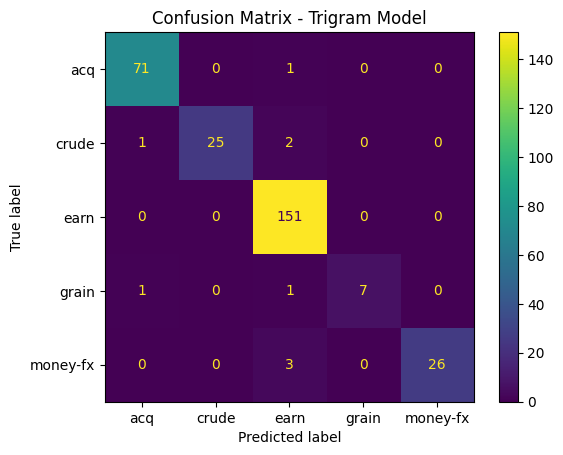

In [20]:
# Initiate a confusion matrix
cm = confusion_matrix(y_test, preds)

# Get unique target labels
labels = sorted(y_test.unique())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.title("Confusion Matrix - Trigram Model")
plt.show()

In [21]:
# Obtain the bigram's macro average results for the classification evaluation metrics
tri_macro_avg = classification_report(y_test, preds, output_dict=True)["macro avg"]
tri_macro_avg

{'precision': 0.9856597884515346,
 'recall': 0.9106595511767924,
 'f1-score': 0.9441014790028757,
 'support': 289.0}

In [22]:
# Final Check: Laplace Smoothing
# Compare the classification result with and without Laplace Smoothing
trigram_no_laplace = MultinomialNB()
# Apply Laplace smoothing by adding one to the zero-observed instances
trigram_laplace = MultinomialNB(alpha=1.0)

# Train the model
trigram_no_laplace.fit(X_train_transformed, y_train)
trigram_laplace.fit(X_train_transformed, y_train)

# Make predictions over the test set and compare macro averaged F1 scores
fscore_no_laplace = f1_score(y_test, trigram_no_laplace.predict(X_test_transformed), average="macro")
fscore_laplace = f1_score(y_test, trigram_laplace.predict(X_test_transformed), average="macro")

if fscore_no_laplace == fscore_laplace:
    print("No difference, smoothing is not necessary.")

No difference, smoothing is not necessary.


### Model Comparison

In [23]:
# Create a result df from the results of different language models
df = pd.DataFrame([uni_macro_avg, bi_macro_avg, tri_macro_avg], index=['Unigram', 'Bigram', 'Trigram'])
macro_result = df.drop(columns="support")
macro_result.round(4)

,precision,recall,f1-score
Unigram,0.9931,0.9778,0.9847
Bigram,0.9905,0.9681,0.9785
Trigram,0.9857,0.9107,0.9441


**Discussion:**

The unigram model achieves the best performance with the highest precision (0.9931), recall (0.9778), and F1-score (0.9847), which demonstrates that single-word features effectively capture the distinct vocabularies of the top five classes in the Reuters-21578 dataset. The bigram model shows slightly lower scores, likely due to increased feature space and potential sparsity. The trigram model performs the worst, with a significant drop in recall (0.9107), indicating overfitting and reduced generalization. Overall, the results highlight that more straightforward unigram representations outperform more complex n-grams for this classification task, as the dataset's categories are well-separated by individual word features.

# END